In [43]:
import numpy as np
import mdtraj as mdtraj
import pandas
import matplotlib.pyplot as plt
import nglview

In [44]:
traj = mdtraj.load('pull.xtc', top='step7.gro')
traj.restrict_atoms(traj.topology.select("protein"))
df = pandas.read_csv("data.csv")

In [45]:
traj.superpose(traj, 0)

<mdtraj.Trajectory with 606 frames, 334 atoms, 16 residues, and unitcells at 0x7f7bc22957f0>

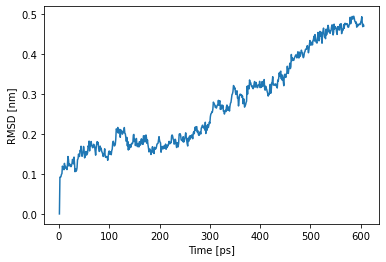

In [46]:
rmsds = mdtraj.rmsd(traj, traj, 0)
plt.close(1)  # This is needed to rerun the code cell correctly
plt.figure(1)
plt.plot(df["Time (ps)"], rmsds)
plt.xlabel("Time [ps]")
plt.ylabel("RMSD [nm]")
plt.show()

In [47]:
view = nglview.show_mdtraj(traj)
view.add_representation('cartoon', selection="protein")
view

NGLWidget(max_frame=605)

In [48]:
# We first need to change the shape of the array with atomic positions.
print(traj.xyz.shape)
xyz = traj.xyz.reshape((-1, traj.n_atoms * 3))
print(xyz.shape)
# rowvar=True indicates that every row is one time step (or frame).
# The first 250 steps are skipped because they cover the initialization phase.
covar = np.cov(xyz[250:], rowvar=False)
print(covar.shape)
# Show the matrix elements corresponding to carbon atoms
selection = traj.top.select("name CA")
# Select the correct Cartesian components of atomic coordinates
selection_xyz = np.array([3*selection, 3*selection + 1, 3*selection + 2]).T.ravel()
plt.matshow(covar[selection_xyz][:,selection_xyz])
print(covar.min())
print(covar.max())

(606, 334, 3)
(606, 1002)
(1002, 1002)


AttributeError: 'Constant' object has no attribute 'kind'

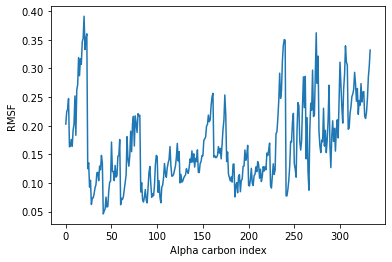

In [50]:
# of each atom are summed, such that one value part alpha
# carbon is retained.
rmsf = np.sqrt(np.diag(covar)[selection_xyz].reshape(-1, 3).sum(axis=1))
plt.close(2)  # This is needed to rerun the code cell correctly
plt.figure(2)
plt.plot(rmsf)
plt.xlabel("Alpha carbon index")
plt.ylabel("RMSF")
plt.show()

In [51]:
rmsf_alt = np.sqrt(np.var(xyz[250:], axis=0)[selection_xyz].reshape(-1, 3).sum(axis=1))
print(rmsf[:5])
print(rmsf_alt[:5])

[0.2027894  0.22389158 0.22883925 0.24727221 0.16311795]
[0.20250438 0.2235769  0.22851764 0.24692468 0.16288868]


[0.07156323 0.08751798 0.09278817 0.12278877 0.16217442 0.25240856
 0.37867273 0.81134492 0.99582907 6.97160747]


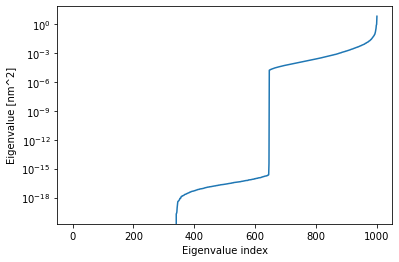

In [52]:
evals, evecs = np.linalg.eigh(covar)
# Print the10 most significant eigenvalues.
print(evals[-10:])
plt.close(3)  # This is needed to rerun the code cell correctly
plt.figure(3)
plt.semilogy(evals)
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue [nm^2]")
plt.show()

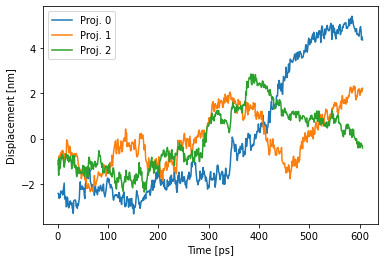

In [53]:
plt.close(4)  # This is needed to rerun the code cell correctly
plt.figure(4)

# Compute the average geometry
av = xyz.mean(axis=0)
# Plot projections on the three-most significant principal modes.
for i in range(3):
    proj = np.dot(xyz - av.reshape(1, -1), evecs[:, -i - 1])
    plt.plot(df["Time (ps)"], proj, label="Proj. {}".format(i))
plt.xlabel("Time [ps]")
plt.ylabel("Displacement [nm]")
plt.legend(loc=0)
plt.show()

In [54]:
# The filtering algorithm
xyz_filter = 0
# Motions along the three most significant modes are retained.
for i in 0, 1, 2:
    evec = evecs[:, -i - 1]
    proj = np.dot(xyz - av.reshape(1, -1), evec)
    xyz_filter += np.outer(proj, evec)
xyz_filter += av

# Finally, we cast the result back into an MDTraj trajectory and visualize it.
traj_filter = mdtraj.Trajectory(xyz_filter.reshape(-1, traj.n_atoms, 3), traj.topology)
view_filter = nglview.show_mdtraj(traj_filter)
view_filter.add_representation("ball+stick", selection="protein")
view_filter

NGLWidget(max_frame=605)

In [55]:
# The amplitude is taken from the maximum eigenvalue
# of the covariance matrix. This will always have the
# right order of magnitude.
amplitude = np.sqrt(evals.max())
# With evecs[:, -1], the last eigenmode,
# i.e. the first principal mode, is selected.
xyz_extra = np.outer(np.linspace(-amplitude, amplitude, 100), evecs[:, -1]) + av

# Again, we cast the result back into an MDTraj trajectory and visualize it.
traj_extra = mdtraj.Trajectory(xyz_extra.reshape(-1, traj.n_atoms, 3), traj.topology)
view_extra = nglview.show_mdtraj(traj_extra)
view_extra.add_representation("ball+stick", selection="protein")
view_extra

NGLWidget(max_frame=99)